# Randomization Methods
- Randomization ensures that experimental groups are comparable and reduces bias.
- Used in A/B testing, clinical trials, marketing experiments, and product feature rollouts.
- Common goals:
    - Preventing selection bias
    - Balancing confounding variables
    - Ensuring statistical validity

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

### Simple Randomization
- <b>Use case</b>: Best for large sample sizes where random chance ensures balance.
- <b>How it works</b>: Each unit (user, patient, product) is assigned randomly to a treatment or control group.

In [5]:

# Simulating 100 users
np.random.seed(40)
simple_users = pd.DataFrame({'user_id': range(1, 101)})

# Random assignment (50% Treatment, 50% Control)
simple_users['group'] = np.random.choice(['Treatment', 'Control'], size=len(simple_users))
simple_users.groupby(simple_users['group']).count()


,user_id
group,
Control,55
Treatment,45


### Stratified Randomization
- <b>Use case</b>: When certain characteristics (e.g., age, gender, location) must be balanced across groups.
- <b>How it works</b>: Divide the sample into strata (subgroups) and randomize within each.

In [7]:
# Simulating 100 users with age groups
strat_users = pd.DataFrame({'user_id': range(1, 101)})
strat_users['age_group'] = np.random.choice(['18-25', '26-40', '41-60'], size=len(strat_users))

# Stratified randomization (ensuring equal treatment/control split within each age group)
strat_users['group'] = strat_users.groupby('age_group')['user_id'].transform(lambda x: np.random.choice(['Treatment', 'Control'], size=len(x)))

strat_users.groupby([strat_users['group'],strat_users['age_group']]).count()

user_id
group     age_group         
Control   18-25           14
          26-40           23
          41-60           14
Treatment 18-25           15
          26-40           16
          41-60           18

### Adaptive Randomization
- <b>Use case</b>: Dynamically assigns more participants to the better-performing group.
- <b>How it works</b>:
    - Adjusts probabilities over time based on observed outcomes.
    - This snippet generates posterior samples from a Beta distribution for Bayesian A/B testing.
    - This code is likely used to compare two groups (e.g., Treatment vs. Control) in an A/B test.
    - It models the probability of success using Bayesian inference, assuming a Beta distribution as the prior.
    - In Bayesian inference, the Beta distribution is a common prior for Bernoulli/binomial probabilities.
    - If we assume the probability of success follows a Binomial likelihood, the Beta distribution serves as a conjugate prior.
    - The prior is typically Beta(1,1) (Uniform), and after observing data (successes and failures), the posterior becomes:
        - <i> Beta(successes + 1, failures +1) </i>

In [8]:
# Simulating observed conversions in each group
successes = {'Treatment': 30, 'Control': 20}
failures = {'Treatment': 70, 'Control': 80}

# Sampling for adaptive assignment
treatment_sample = beta.rvs(successes['Treatment'] + 1, failures['Treatment'] + 1, size=1000)
control_sample = beta.rvs(successes['Control'] + 1, failures['Control'] + 1, size=1000)

# Probability of Treatment being better
prob_treatment_better = (treatment_sample > control_sample).mean()
print(f"Probability that Treatment is better: {prob_treatment_better:.2%}")

# Compute the credible interval (95% CI)
treatment_ci = np.percentile(treatment_sample, [2.5, 97.5])
control_ci = np.percentile(control_sample, [2.5, 97.5])

print(f"Probability Treatment is better: {prob_treatment_better}")
print(f"95% CI for Treatment: {treatment_ci}")
print(f"95% CI for Control: {control_ci}")

Probability that Treatment is better: 95.20%
Probability Treatment is better: 0.952
95% CI for Treatment: [0.22335843 0.3947202 ]
95% CI for Control: [0.13316712 0.28128884]


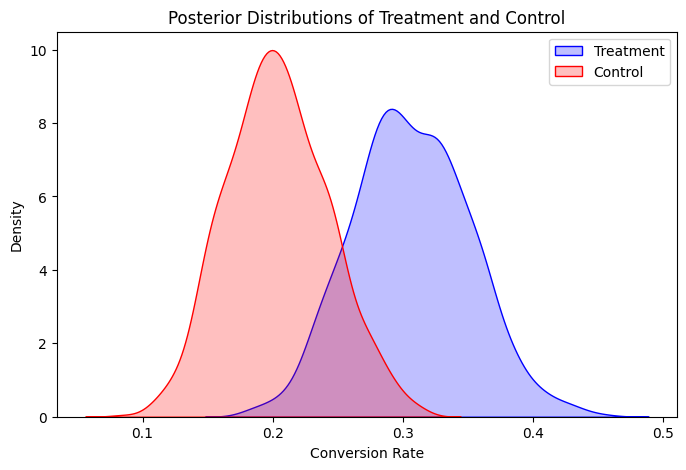

In [9]:
# Plot the distributions
plt.figure(figsize=(8, 5))
sns.kdeplot(treatment_sample, label="Treatment", fill=True, color="blue")
sns.kdeplot(control_sample, label="Control", fill=True, color="red")

# Labels and legend
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.title("Posterior Distributions of Treatment and Control")
plt.legend()
plt.show()

# Randomization Quality Checks
After randomization, one should validate that the assignment is truly random and that key variables are balanced across groups. Here are some ways to check if the sample is well-randomized:

### T-test for Balance (Numeric Variables)
- Run a t-test to check if groups have significantly different averages for numerical features.
- A high p-value (typically >0.05) means there is no significant difference, which is good for randomization!

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Simulating 500 users with random ages between 1 and 70
ttest_users = pd.DataFrame({
    'user_id': range(1, 501),
    'age': np.random.choice(range(1, 70), size=500, replace=True)  # Added size=500
})

# Stratified randomization (ensuring equal Treatment/Control split within each age group)
ttest_users['group'] = ttest_users.groupby('age')['user_id'].transform(
    lambda x: np.random.choice(['Treatment', 'Control'], size=len(x), replace=True)  # Ensuring all users get assigned
)

# Performing independent t-test
t_stat, p_value = ttest_ind(
    ttest_users[ttest_users['group'] == 'Treatment']['age'],
    ttest_users[ttest_users['group'] == 'Control']['age'],
    equal_var=False
)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


T-statistic: 0.491, P-value: 0.624


### Chi-Square Test for Balance (Categorical Variables)
- Check if categorical variables (e.g., gender, location) are evenly split using a Chi-square test.
- A high p-value (>0.05) means the distributions are not significantly different, meaning randomization worked well.

In [21]:
from scipy.stats import chi2_contingency

chi_users = pd.DataFrame({
    'user_id': range(1, 501),
    'age': np.random.choice(range(1, 70), size=500, replace=True),  # Generating random ages
    'gender': np.random.choice(['Male', 'Female'], size=500, replace=True)  # Assigning gender randomly
})

chi_users['group'] = chi_users.groupby(['age','gender'])['user_id'].transform(
    lambda x: np.random.choice(['Treatment', 'Control'], size=len(x), replace=True))  # Ensuring all users get assigned)

# Create a contingency table
contingency_table = pd.crosstab(chi_users['group'], chi_users['gender'])

print(contingency_table)

gender     Female  Male
group                  
Control       126   135
Treatment     123   116


In [22]:
# Run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.3f}, P-value: {p:.3f}")

Chi-square statistic: 0.388, P-value: 0.533


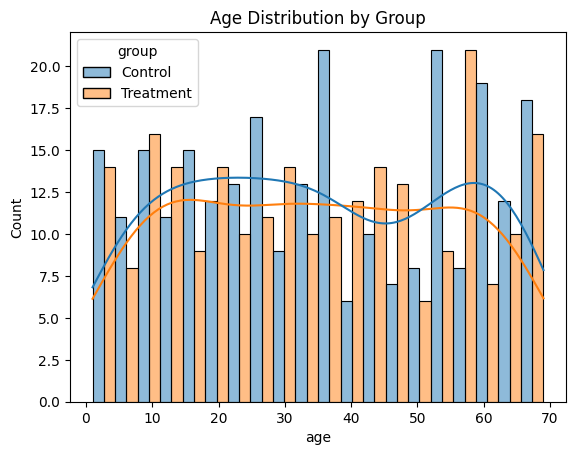

In [24]:
sns.histplot(data=chi_users, x='age', hue='group', bins=20, kde=True, multiple="dodge")
plt.title("Age Distribution by Group")
plt.show()

### Checking Covariate Balance with Standardized Mean Differences (SMD)
- The Standardized Mean Difference (SMD) measures imbalance.
    - |SMD| < 0.1 → Good balance
    - |SMD| > 0.1 → Potential imbalance

In [29]:
def smd(a, b):
    return (a.mean() - b.mean()) / np.sqrt((a.var() + b.var()) / 2)

#Using chi_users itself since I'm a little lazy
smd_value = smd(chi_users[chi_users['group'] == 'Treatment']['age'],
                chi_users[chi_users['group'] == 'Control']['age'])

print(f"Standardized Mean Difference (SMD): {abs(smd_value):.3f}")

Standardized Mean Difference (SMD): 0.018


# Final Thoughts

If you find imbalance, consider:
- Larger sample size – Small groups may be imbalanced just by chance.
- Stratified randomization – If a key variable (e.g., gender, income) is imbalanced, stratify on it.
- Blocked randomization – Ensures equal group sizes when sample size is small.